In [18]:
import pathlib, sys, os, random, time
import torch
from torch import nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import numpy as np

In [19]:
# mounting google drive
collaboratory = False

if collaboratory:
    from google.colab import drive
    drive.mount('/gdrive')
    # !ln -s "/gdrive/Shareddrives/HSC_project/HSC_ML" "/content/HSC_ML"
    os.chdir("/gdrive/Shareddrives/HSC_project/HSC_ML")
else: 
    print('Running on local systems, if running on collaboratory please change above')

print(os.listdir())
# print(os.getcwd())
#!unzip ./HSC_ML/Output/TBCells_crops.zip -d ./HSC_ML/Output/

Running on local systems, if running on collaboratory please change above
['test.ipynb', 'Training_khayrul.ipynb', 'Training.ipynb']


# spliting dataset into train and test

In [20]:
train_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ColorJitter(brightness = 0.25, contrast=0.25),
    transforms.RandomRotation(90),
    #transforms.RandomRotation(degrees=(90, 90)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),

])

val_transform = transforms.Compose([transforms.Resize((128, 128)),transforms.ToTensor()])

In [23]:
import sklearn.model_selection

if collaboratory:
  image_folder = "./Output/"
else:
  image_folder = "../../Output/TBCells_crops/Train_data/"
trained_weights = image_folder[:-11]+"Results/Latest_Weight"

if not os.path.exists(trained_weights):
        os.makedirs(trained_weights)


dataset = datasets.ImageFolder(image_folder, transform=train_transform)

train_indices, val_indices = sklearn.model_selection.train_test_split(
                    list(range(dataset.__len__())),          # list of indices of dataset
                    stratify = dataset.targets,                 # for stratify sampling the data due to the unblanced dataset
                    random_state = 42,
                    test_size=.25                               #represent the proportion of the dataset to include in the train split.
                    )



# subsetting the dataset into train and test
training_data = torch.utils.data.Subset(dataset, train_indices)
test_data = torch.utils.data.Subset(dataset, val_indices) 

print(f"Length of dataset:" )
print(f" {'Train dataset':<12}   \u2502   {'Test data':>12} ")
print(f" {len(training_data):<12}    \u2502   {len(test_data) :>12}")



Length of dataset:
 Train dataset   │      Test data 
 24558           │           8186


# Iterating and Visualizing the Dataset

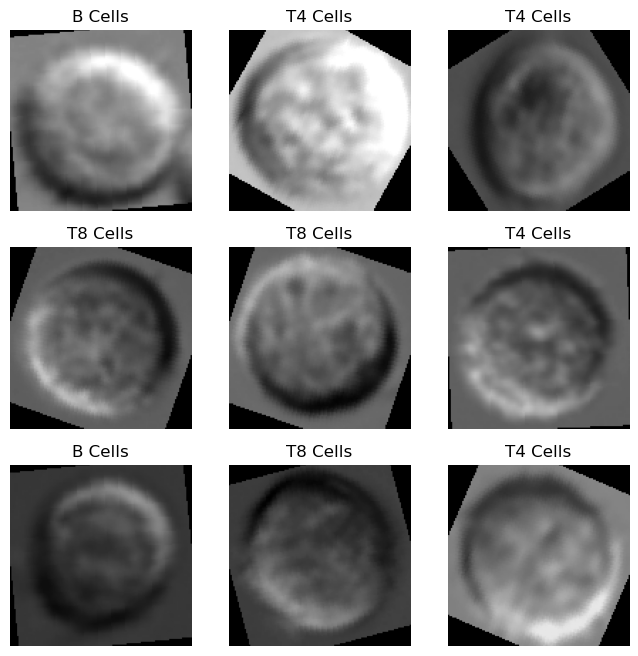

In [5]:
labels_map = {
    0: "B Cells",
    1: "T4 Cells",
    2: "T8 Cells",

}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.permute(1,2,0), cmap="gray") 
plt.show()

In [6]:

batch_size = 64

# setting sampler weight
y_train_indices = training_data.indices
y_train = [dataset.targets[i] for i in y_train_indices]
class_sample_count = np.array(
    [len(np.where(y_train == t)[0]) for t in np.unique(y_train)])

weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in y_train])
sampler = torch.utils.data.sampler.WeightedRandomSampler(samples_weight, len(samples_weight), replacement=True) 


# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size= batch_size,sampler = sampler, pin_memory=True)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print("Shape of X [N, C, H, W]: ", X.shape)
    print("Shape of y: ", y.shape, y.dtype)
    break

Shape of X [N, C, H, W]:  torch.Size([64, 3, 128, 128])
Shape of y:  torch.Size([64]) torch.int64


# Training the model

In [7]:
# defining the model

import torchvision.models as models

DEVICE = torch.device("cuda:1" if torch.cuda.is_available() else 'cpu')
print("Cuda acceleration enabled!" if torch.cuda.is_available() else 'Running on CPU')


def get_model():
    # initializing with resnet weight
    model = models.resnet50(weights="IMAGENET1K_V1")

    # get the input feature in fully connected layer
    num_in_features = model.fc.in_features

    # Replace the final fully connected layer to suite the problem
    model.fc = nn.Sequential(nn.Linear(num_in_features, 512),
                                    nn.ReLU(),
                                    nn.Dropout(0.3),
                                    nn.Linear(512, 3))
    
    # using gpu
    model = model.cuda() if torch.cuda.is_available() else model
    # print(model)
    return model


@torch.no_grad()
def validation(model, train_dataloader, loss_fn):
    losses = []
    model.eval()
    for image, target in train_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        output = model(image)
        loss = loss_fn(output, target)
        losses.append(loss.item())
        
    return np.array(losses).mean()


def loss_fn(y_pred, y_true):
    bce_fn = nn.CrossEntropyLoss()
    loss = bce_fn(y_pred, y_true)
    return loss


### Table for results
header = r'''
        Train | Valid
Epoch |  Loss |  Loss | Time, m | Save status
'''
#          Epoch         metrics            time
raw_line = '{:6d}' + '\u2502{:7.3f}'*2 + '\u2502{:6.2f}' + '\t' + '\u2502 {}'


Cuda acceleration enabled!


In [8]:
# loading the model

model = get_model()

model.to(DEVICE)

# not optimizing the whole network for now
# optimizer = torch.optim.AdamW(model.parameters(),
#                   lr=1e-4, weight_decay=1e-3)

ignored_params = list(map(id, model.fc.parameters()))
base_params = filter(lambda p: id(p) not in ignored_params,
                     model.parameters())
#??? why we have 2 learning rate
learning_rate = 4e-3
optimizer = torch.optim.Adam([
            {'params': base_params},
            {'params': model.fc.parameters(), 'lr': learning_rate}
        ], lr = learning_rate * 0.01)

In [9]:
EPOCHES = 35
vloss_min = np.Inf
print(header)

for epoch in range(1, EPOCHES+1):
    losses = []
    start_time = time.time()
    model.train()
    for image, target in train_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)
        optimizer.zero_grad()
        output = model(image)
        loss = loss_fn(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
    vloss = validation(model, test_dataloader, loss_fn)
    batch_loss = np.array(losses).mean()
    
    if vloss_min > vloss:
        vloss_min = vloss
        torch.save(model.state_dict(), trained_weights +'TBCells.pt')
        save_status = 'Yes'
    else:
        save_status = 'No'
        
    print(raw_line.format(epoch, batch_loss, vloss,
                              (time.time()-start_time)/60**1, save_status))


        Train | Valid
Epoch |  Loss |  Loss | Time, m | Save status

     1│  0.969│  0.789│  2.25	│ Yes
     2│  0.760│  0.706│  2.17	│ Yes
     3│  0.703│  0.761│  2.30	│ No
     4│  0.671│  0.639│  2.32	│ Yes
     5│  0.655│  0.630│  2.27	│ Yes
     6│  0.647│  0.599│  2.21	│ Yes
     7│  0.623│  0.631│  2.23	│ No
     8│  0.619│  0.609│  2.17	│ No
     9│  0.596│  0.590│  2.13	│ Yes
    10│  0.591│  0.584│  2.32	│ Yes
    11│  0.593│  0.632│  2.13	│ No
    12│  0.571│  0.582│  2.19	│ Yes
    13│  0.569│  0.601│  2.19	│ No
    14│  0.562│  0.571│  2.24	│ Yes
    15│  0.558│  0.563│  2.12	│ Yes
    16│  0.546│  0.571│  2.15	│ No
    17│  0.546│  0.537│  2.18	│ Yes
    18│  0.540│  0.557│  2.22	│ No
    19│  0.527│  0.550│  2.15	│ No
    20│  0.524│  0.538│  2.18	│ No
    21│  0.527│  0.536│  2.21	│ Yes
    22│  0.509│  0.562│  2.25	│ No
    23│  0.505│  0.533│  2.29	│ Yes
    24│  0.513│  0.541│  2.16	│ No
    25│  0.503│  0.524│  2.08	│ Yes
    26│  0.481│  0.547│  2.25	│ No
    27

# Reconstruct model from saved weights

In [ ]:
restart = False
if restart:
    model1 = torchvision.models.resnet50()
    model1.fc = torch.nn.Sequential(
        torch.nn.Linear(
            in_features=2048,
            out_features=1
        ),
        torch.nn.Sigmoid()
    )
    model1.load_state_dict(torch.load(trained_weights +'TBCells.pt'))

# Evaluating results

In [10]:
# validating dataset

from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

trained_model_PATH = trained_weights +'TBCells.pt'
model.load_state_dict(torch.load(trained_model_PATH))
model.eval()

y_pred = []
y_true = []


with torch.no_grad():
    for image, target in test_dataloader:
        image, target = image.to(DEVICE), target.to(DEVICE)

        outputs = model(image)
        
        output = (torch.max(outputs, 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        
        target = target.data.cpu().numpy()
        y_true.extend(target) # Save Truth
        

average acuraccy of all classes: 78.43634423001394


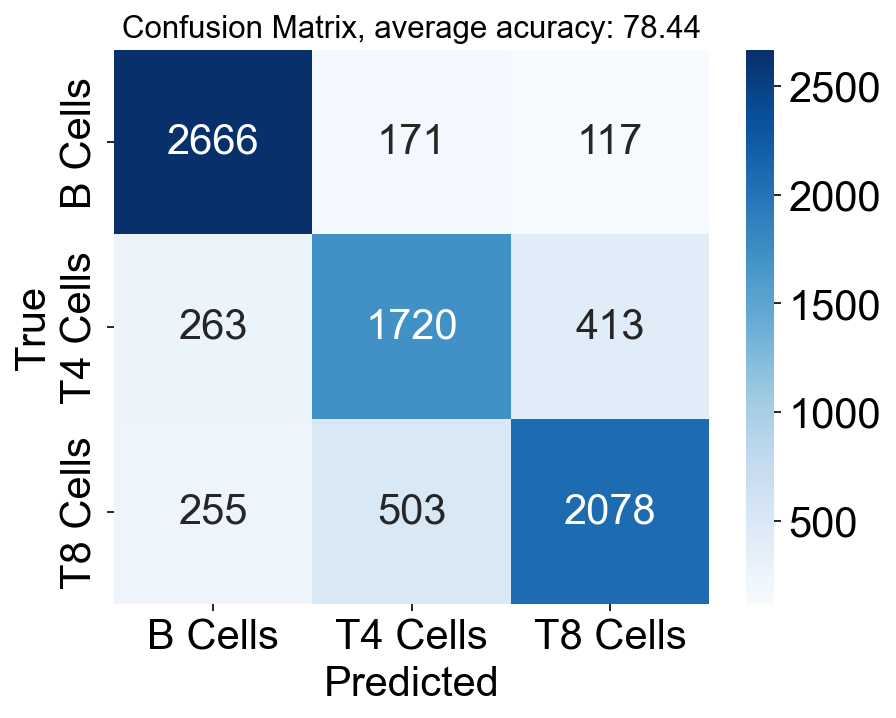

In [17]:
classes = labels_map.values()   
 
# Build confusion matrix
cf_matrix = confusion_matrix(y_true, y_pred)

class_accuracy=np.mean(100*cf_matrix.diagonal()/cf_matrix.sum(1))
print(f'average acuraccy of all classes: {class_accuracy}')

# ploting 
font = {'family' : 'Arial',
        'size'   : 20}

plt.rc('font', **font)
fig, ax = plt.subplots( dpi = 150)
sn.heatmap(cf_matrix, annot=True, cmap='Blues',fmt='g')
ax.set_title(f'Confusion Matrix, average acuracy: {class_accuracy :.2f}', fontsize = 15)
ax.xaxis.set_ticklabels(classes); ax.yaxis.set_ticklabels(classes);
plt.xlabel('Predicted'); plt.ylabel('True');

plt.savefig(trained_weights + 'cf_matrix.png', bbox_inches='tight')

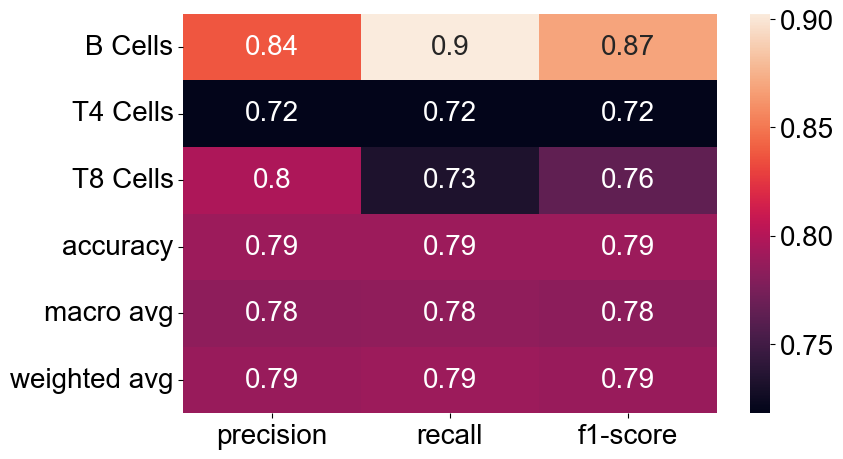

In [14]:
# classification report

from sklearn.metrics import classification_report
import seaborn as sns

cls_report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)
df = pd.DataFrame(cls_report)
# df.drop(columns=['accuracy'])

fig, ax = plt.subplots(1, 1, figsize = (9, 5))

sns.heatmap(df.iloc[:-1, :].T, annot=True)
fig.tight_layout()
plt.savefig(trained_weights + "classification_report.png", bbox_inches='tight', dpi=150)

In [38]:
#pip install keyboard
#import keyboard
#keyboard.press_and_release('command+s')

nb_name = "test.ipynb"
nb_full_path = os.path.join(os.getcwd(), nb_name)

import shutil
shutil.copyfile(nb_full_path, trained_weights +"/" + nb_name)


'../../Output/TBCells_crops/Results/Latest_Weight/test.ipynb'